# Basic Demo and debugging of the xQAOA solver. 

## Problem Setup and Classical Solutions

First we load the solver and some basic tools. 

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from scripts.solvers.qkp_solver import *
from scripts.utils.kp_utils import *
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Pauli
from qiskit.transpiler.passes import LightCone, RemoveBarriers
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_dag, dag_to_circuit

Then lets initialize our hard knapsack distribution, including the capacity contraint. We end with a plot of all the items in the knapsack and their values and weights.

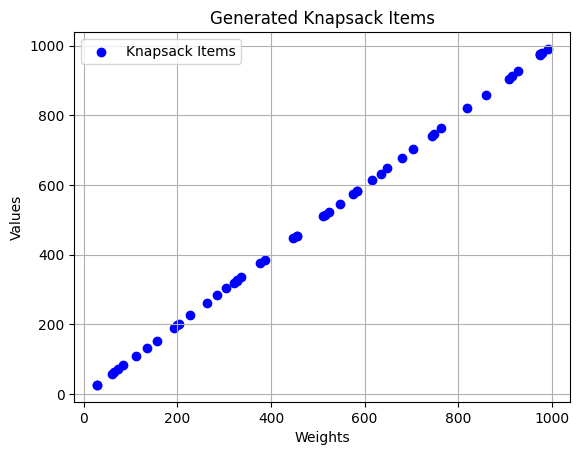

In [50]:
n = 50  # Number of items
d = 4  # Technical term in definition of profit distribution setting how far values can differ from weights
[weights,values] = generate_profit(n, d) # create the list of knapsack items
capacity = 0.7 * np.sum(weights)  # Set weight limit to 70% of total weight

# Plot the knapsack items
plt.scatter(weights, values, color='blue', marker='o', label='Knapsack Items')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

Note the relationship between items weight and their value is essentially linear with value equal to the weight rounded down to the nearest multiple of $d$. 

A useful way to visualize this is to plot the ratio of value/weight against the weights. 

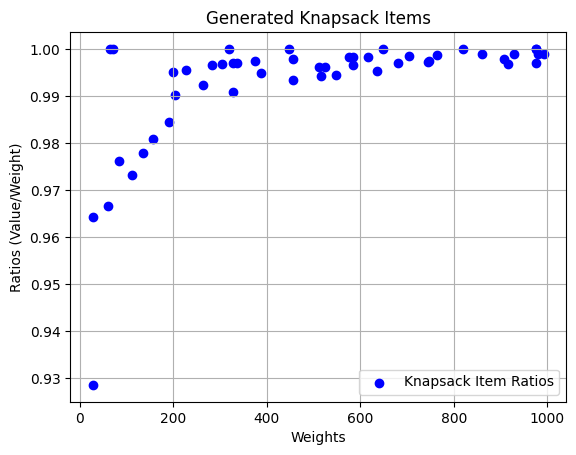

In [51]:
ratios = values / weights
plt.scatter(weights, ratios, color='blue', marker='o', label='Knapsack Item Ratios')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Ratios (Value/Weight)')
plt.legend()
plt.grid(True)
plt.show()

Now lets solve the problem with Gurobi and plot the optimal solution.

Total Value of optimal solution: 17170
Total Weight of optimal solution: 17196
Runtime: 0.008000 seconds


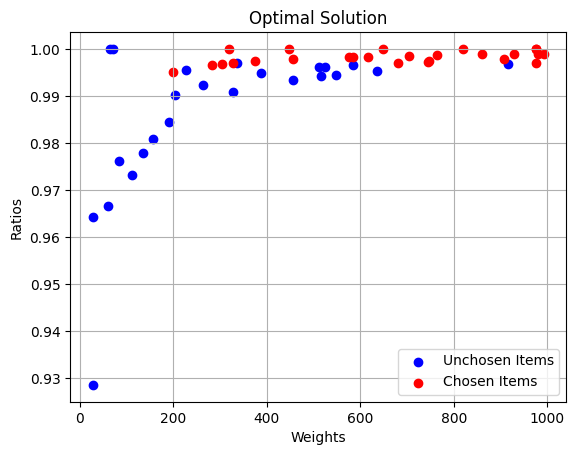

In [52]:
# Solve the knapsack problem using Gurobi
result_gurobi = gurobi_knapsack_solver(values, weights, capacity, verbose=False,
                                        time_limit=60,
                                        optimality_gap=1e-20,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

# And print some output statistics
# print(f"Optimization Results Gurobi -- {n} items")
# print(f"Bitstring: {result_gurobi['bitstring']}")
print(f"Total Value of optimal solution: {result_gurobi['total_value']}")
print(f"Total Weight of optimal solution: {result_gurobi['total_weight']}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

As a sanity check, lets construct the greedy solution and see how it compares to Gurobi. 

Greedy Solution Value: 17159
Greedy Solution Weight: 17184


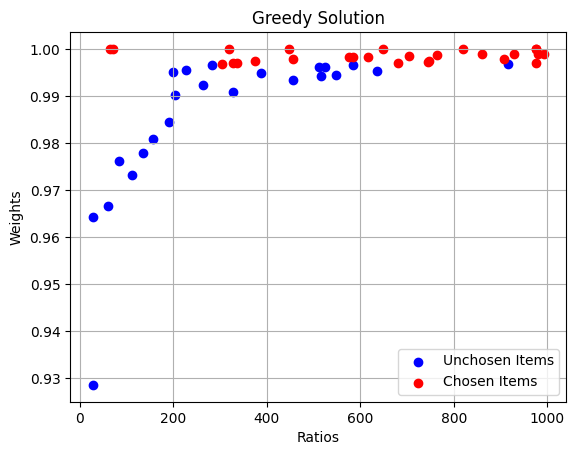

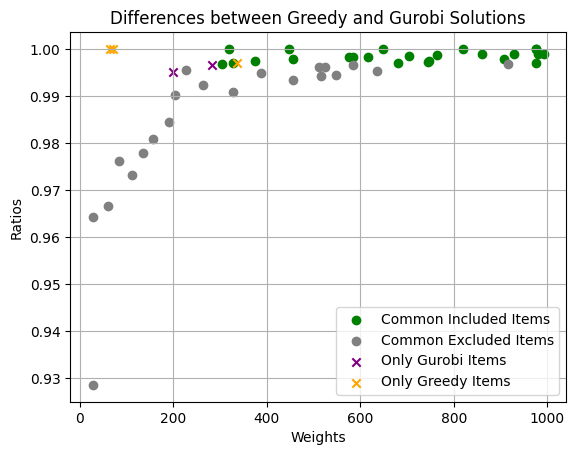

In [53]:
greedy_weight = 0
greedy_solution = np.zeros(n, dtype=bool)

# Order items by their ratio with weight as the tiebreaker
greedy_order = np.lexsort((-weights, -ratios))

for i in greedy_order:
    if greedy_weight + weights[i] <= capacity:
        greedy_solution[i] = True
        greedy_weight += weights[i]
    
greedy_value = np.sum(values[greedy_solution])
print(f"Greedy Solution Value: {greedy_value}")
print(f"Greedy Solution Weight: {greedy_weight}")
# Plot the greedy solution
plt.figure()
plt.scatter(weights[~greedy_solution], ratios[~greedy_solution], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[greedy_solution], ratios[greedy_solution], color='red', marker='o', label='Chosen Items')
plt.title('Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

# Plot the indices where the greedy solution and Gurobi solution differ
diff_indices = np.logical_xor(greedy_solution, soln_mask)
diff_gurobi_solutions = np.logical_and(soln_mask, diff_indices)
diff_greedy_solutions = np.logical_and(greedy_solution, diff_indices)
common_solutions = np.logical_and(greedy_solution, soln_mask)
common_excluded = np.logical_and(~greedy_solution, ~soln_mask)
plt.figure()
plt.scatter(weights[common_solutions], ratios[common_solutions], color='green', marker='o', label='Common Included Items')
plt.scatter(weights[common_excluded], ratios[common_excluded], color='gray', marker='o', label='Common Excluded Items')
plt.scatter(weights[diff_gurobi_solutions], ratios[diff_gurobi_solutions], color='purple', marker='x', label='Only Gurobi Items')
plt.scatter(weights[diff_greedy_solutions], ratios[diff_greedy_solutions], color='orange', marker='x', label='Only Greedy Items')
plt.title('Differences between Greedy and Gurobi Solutions')
plt.xlabel('Weights')
plt.ylabel('Ratios')
plt.legend()
plt.grid(True)
plt.show()


## Quantum Solution

### Classical Warm Start Distribution

Our starting point for the Quantum Solution is a classical warm start. 

To understand this distribution we first construct the "lazy greedy" classical solution. This is obtained similarly to the greedy classical solution constructed above, only the algorithm stops when it encounters the first item that doesn't fit into the knapsack.

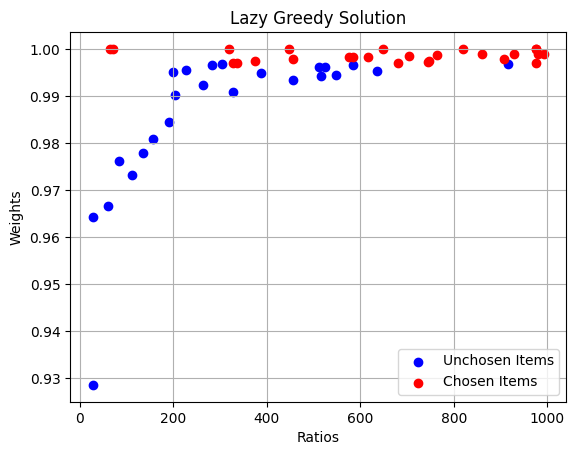

In [54]:
def construct_lazy_greedy_solution(weights, ratios, capacity):
    # Constructs a lazy greedy solution
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(n, dtype=bool)

    # Order items by their ratio with weight as the tiebreaker
    greedy_order = np.lexsort((-weights, -ratios))

    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

lgs = construct_lazy_greedy_solution(weights, ratios, capacity)
plt.figure()
plt.scatter(weights[~lgs], ratios[~lgs], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[lgs], ratios[lgs], color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()



This solution will never be better than the greedy solution visualized above, but it does give us a useful starting point for constructing our warm start distribution. 

As a first step, notice that if we sort items by ratio of (value/weight) the lazy greedy distribution has a cutoff above which all items are included in the solution, and below which items are excluded. 

In the next plot we visualize this as giving a `probability' (either 0 or 1) of being included in the lazy greedy solution. This is to prepare us for the warm start distribution, which we define next. 



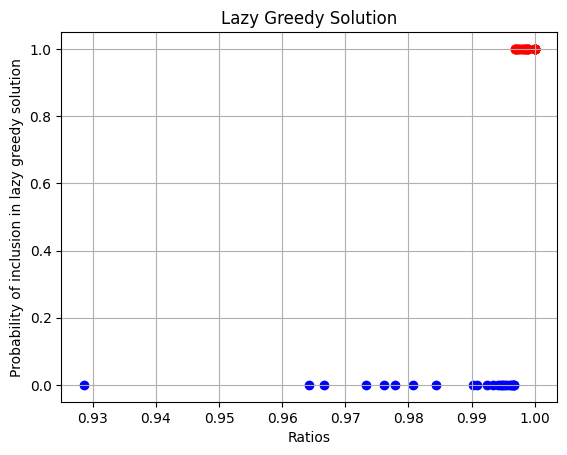

In [55]:
plt.figure()
plt.scatter(ratios[~lgs], np.zeros_like(values[~lgs]), color='blue', marker='o', label='Unchosen Items')
plt.scatter(ratios[lgs], np.ones_like(values[lgs]), color='red', marker='o', label='Unchosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Probability of inclusion in lazy greedy solution')
plt.grid(True)
plt.show()

Our warm start distribution can now be obtained by "smoothing out" the above probabilities slightly. It is defined in terms of an inverse temperature parameter k. Setting k = infinity produces the lazy greedy distribution above, while setting k = 0 produces a uniform distribution with expected weight equal to the capacity of knapsack. 

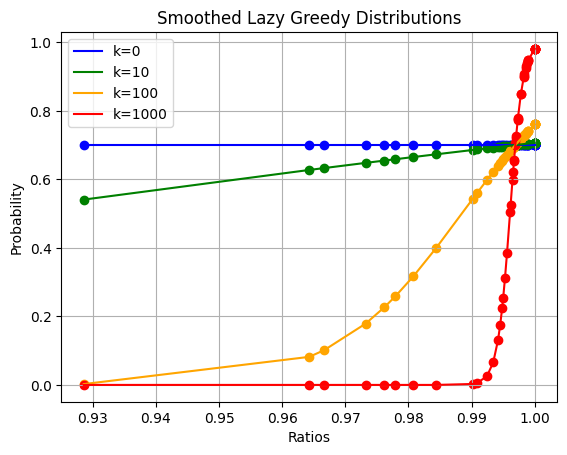

In [56]:

def construct_smoothed_lazy_greedy_distribution(weights, values, capacity, inv_temp):
    # First find the cutoff ratio for the lazy greedy solution.
    lazy_greedy_solution = construct_lazy_greedy_solution(weights, values / weights, capacity)
    cutoff_ratio = np.min(ratios[lazy_greedy_solution]) 
    # Then set some constants so that in the limit of k = 0 we have the correct uniform distribution.
    uniform_probability = np.sum(weights) / capacity

    return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))

# Lets plot some solutions for different values of k
k_values = [0, 10, 100, 1000]
colours = ['blue', 'green', 'orange', 'red']
plt.figure()
for i in range(len(k_values)):
    smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k_values[i])
    plt.scatter(ratios, smoothed_distribution, color=colours[i], marker='o')
    # plot a line through the points
    ordered_indices = np.argsort(ratios)
    plt.plot(ratios[ordered_indices], smoothed_distribution[ordered_indices], color=colours[i], label=f'k={k_values[i]}')
plt.title('Smoothed Lazy Greedy Distributions')
plt.xlabel('Ratios')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


Note that our "solution" is now a probability distribution. We can repeatedly sample from this distribution to understand the quality of the solutions our warm start gives. An important observation is that this distribution will sometimes give solutions which do not respect the capacity restraints of thte knapsack. We must filter those out to get an accurate understanding of the solution quality.  

Best valid solution value is: 17153
Worst invalid solution is: 17158
Optimal solution value is: 17170
Probability of valid samples: 0.493
Approximation ratio of valid samples: 0.9053


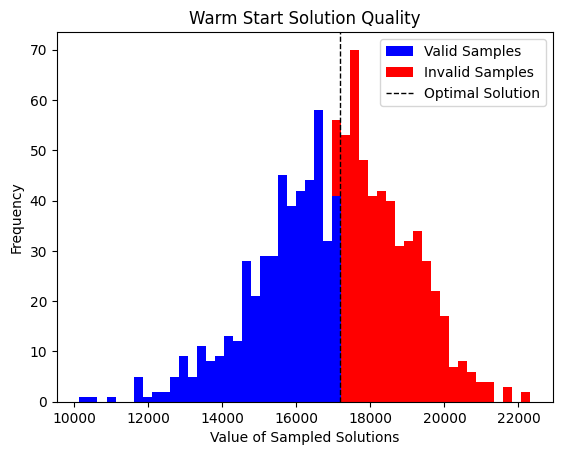

In [57]:
# We will pick k = 100 since it gives a gives a good balance between the uniform and lazy greedy distributions.
k = 100
smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)

# Now sample from this distribtion
num_samples = 1000
samples = np.random.rand(num_samples, len(weights)) < smoothed_distribution
total_values = np.sum(samples * values, axis=1)
total_weights = np.sum(samples * weights, axis=1)
valid_samples = total_weights <= capacity

# Some nice to have statistics
probability_valid = np.sum(valid_samples) / num_samples
approxmation_ratio_of_valid = np.mean(total_values[valid_samples]) / optimal_value

# Lets make a histogram showing the total value of the samples
plt.figure()
plt.hist([total_values[valid_samples],total_values[~valid_samples]], bins=50, stacked = True, color=['blue','red'], label=['Valid Samples', 'Invalid Samples'])
plt.axvline(optimal_value, color='black', linestyle='dashed', linewidth=1, label='Optimal Solution')
plt.title('Warm Start Solution Quality')
plt.xlabel('Value of Sampled Solutions')
plt.ylabel('Frequency')
plt.legend()

print(f"Best valid solution value is: {np.max(total_values[valid_samples])}")
print(f"Worst invalid solution is: {np.min(total_values[~valid_samples])}")
print(f"Optimal solution value is: {optimal_value}")
print(f"Probability of valid samples: {probability_valid}")
print(f"Approximation ratio of valid samples: {approxmation_ratio_of_valid:.4f}")

The fundamental question we investigate next is whether we can improve performance of our solution by postprocessing the distribution with a quantum circuit. 

### Preparing Warm Start Distribution on a Quantum Computer 

In our quantum circuit, each qubit will represent one item in the knapsack. At the end of the circuit we measure all the qubits to produce a solution to the knapsack problem -- if a qubit is measured in the $\ket{1}$ state then the corresponding item will be in the napsack solution, and if is measured in the $\ket{0}$ state the corresponding item will be excluded from the soltuion. 

The first step then, is to initialize a quantum circuit with as many qubits as we have potential items to put in the knapsack. Then we prepare those qubits in a state whose measurement statistics match the warm start distribution described above on a quantum computer. We do this by rotating each qubit about the Y-axis to produce the state $\sqrt{1-p_i}\ket{0} + \sqrt{p_i}\ket{1}$ where $p_i$ is the probability the warm start distribution assignes to the $i$-th item. 

An important detail when we move on to constructing the xQAOA mixer will be the physical layout of our qubits. We order our qubits in terms of increasing ratio, so that adjacent qubits correspond to items with similar ratios of value/weight. When items have an idential ratio we use weight as a tiebreaker.

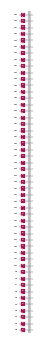

In [58]:
warm_start_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)
qubit_order = np.lexsort((-weights, -ratios))

qubit_ordered_distribution = warm_start_distribution[qubit_order]

qc = QuantumCircuit(n)

def initialize_warm_start_distribution(quantum_circuit, distribution):
    """
    Initializes the quantum circuit with the given distribution.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to initialize.
        distribution (np.ndarray): The distribution to use for initialization.
    """
    for i in range(len(distribution)):
        angle = 2 * np.arcsin(np.sqrt(distribution[i]))
        quantum_circuit.ry(angle, i)  # Rotate qubit i by appropriate angle.
    
    qc.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)

# Lets print our quantum circuit. For now it's pretty basic.
qc.draw('mpl', scale=0.1, idle_wires=False, fold=-1, reverse_bits=True)


As a sanity check, we compute the output probabilities of each qubit in the circuit, and check that the resulting distribution matches the input distribtuion. 

This also gives us an opportunity to introduce the notion of a lightcone estimator. The key observation is that in order to get expectation values give Pauli term we only need to simulate the gates in the backwards lightcone of that Pauli. For the moment we are just estimating single Pauli Z terms, and our backwards lightcone is just a single qubit. 

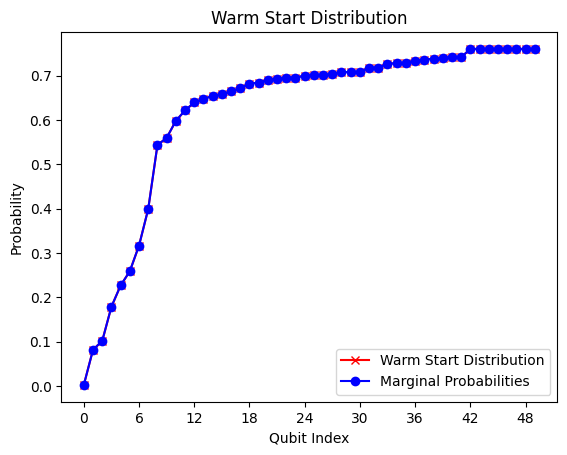

In [59]:
exact_estimator = StatevectorEstimator()
observables = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(n)]

def light_cone_estimate(qc, observable, estimator=exact_estimator):
    """
    Estimates the expectation value of the observable using the lightcone method.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to run.
        observable (Pauli): The observable to estimate.
    
    Returns:
        float: The estimated expectation value.
    """

    pauli_str = observable.to_label()
    # print(f"Pauli string for the observable: {pauli_str}")

    # Find the non-trivial pauli operators in the observable and their indices
    non_trivial_pauli = pauli_str.replace('I', '')
    active_indices = [(len(pauli_str)-1-i) for i, p in enumerate(pauli_str) if p != 'I']
    # print(non_trivial_pauli)
    # print(active_indices)

    # Apply the light cone pass to the circuit
    light_cone_pass = LightCone(bit_terms=non_trivial_pauli, indices=active_indices)
    pm = PassManager([RemoveBarriers(),light_cone_pass])
    red_qc = pm.run(qc)

    # Now we've got to remove the unused wires from our circuit so that exact_estimator doesn't choke.
    # We do this by converting to a DAG, then identifying and removing the idle wires.
    # We also need to remove the corresponding Pauli operators from the observable. 
    # Note the remaining Pauli observable can be larger than non_trivial_pauli above, since it may contain
    # some I corresponding to qubits in the backwards lightcone of the active qubits.
    red_dag = circuit_to_dag(red_qc)
    qubits_to_remove = list(red_dag.idle_wires())
    indices_to_remove = [len(pauli_str) - 1 - red_dag.find_bit(q).index for q in qubits_to_remove]
    for q in qubits_to_remove:
        red_dag.remove_qubits(q)
    truncated_observable = Pauli(''.join([p for i, p in enumerate(pauli_str) if i not in indices_to_remove]))
    red_qc = dag_to_circuit(red_dag)

    # Run the estimator with the smaller circuit and the truncated observable.
    exact_sim = exact_estimator.run([(red_qc, truncated_observable)])
    
    return exact_sim.result()[0].data.evs

# Get Pauli Z expectation values (exact) using the lightcone method, then convert to probabilities
pauli_z_evs = [light_cone_estimate(qc, obs) for obs in observables]
marginal_probs = (1 - np.array(pauli_z_evs)) / 2

# Plot probabilities and compare with warm start distribution. Note we have to reverse the order of the qubits due to little-endian ordering.
plt.plot(qubit_ordered_distribution[::-1], marker='x', linestyle='-', color='red', label='Warm Start Distribution')
plt.plot(marginal_probs, marker='o', linestyle='-', color='blue', label='Marginal Probabilities')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Warm Start Distribution')
plt.xlabel('Qubit Index')
plt.ylabel('Probability')   
plt.legend()
plt.show()


# print(f"Marginal probabilities: {maginal_probs}")
# print(f"Warm Start Distribution: {qubit_ordered_distribution}")
# print(f"Test Exact Simulation Result: {test_exact_sim}")


#compare with  estimator
# exact_sim_estimate = exact_estimator.run([(qc, observables[3])]).result()[0].data.evs
# print(f"Exact Simulation Result: {exact_sim_estimate}")
#compare with probability distribution
# print(f"Should be equal to: {qubit_ordered_distribution[0]}")

# print(exact_sim.result()[0])

## The Copula Mixer

Now that we have initialized the warm start distribution on a quantum computer, we can use standard optimization techniques to try and shift the state towards an optimal (or near-optimal) knapsack solution. But if we try to apply standard QAOA techinques we encounter a problem. The knapsack problem is a constrained optimization problem, while QAOA is most naturally suited to *unconstrained* otpmization. It is always possible to add constraints, in the form of a penalty term, to the QAOA cost function then proceed like normal. But this approach complicates the cost function, and may (for inequality constraints as in the knapsack problem) also requires introducing slack variables which drive up the qubit count.  

An alternate approach to constrained optimization is to modify the QAOA mixer, so that the mixer dynamics naturally respect the constraints of the problem. But pursuing this approach in the case of the knapsack problem requires performing coherent addition between the qubits, which is out of scope for current quantum hardware. 

Here we pursure an alternate approach -- proposed in https://arxiv.org/abs/2108.08805 -- in which we modify the mixer in a way that we hope will approximately respect the knapsack constraints. This is less costly then the approach described in the previous paragraph, but still gives a way of partially incorporating constraints into the QAOA framework. 

The basic building block of this appraoch is a two-qubit mixer which we call the Copula mixer.

## Bug/concerns as compared to main code:

* Value of $r^*$ when defining the smoothed lazy greedy distribution. Should be set so that at $k = \infty$ we arrive at the lazy greedy distribuion (see Alg 6 in https://arxiv.org/pdf/2108.08805). But in qkp.solver.py it looks like it's just set to the average. 

* Qubits should be ordered so that adjacent qubits have similar ratios before applying Copula mixer. See discussion in 5.2.3 in (https://arxiv.org/pdf/2108.08805).

* I had to fiddle a bit to get the lightcone estimator to delete unused qubits and corresponding 'I' terms in the observables. It's unclear to me if this is faster (maybe StatevectorEstimator clears these automatically?), but my computer was throwing some index out of bounds error for larger qubit counts without that step. Makes me think StatevectorEstimator is carrying around more info than it needs to without manually deleting idle qubits.
